# ECMWF API plugin for EODAG

This tutorial will show you how use eodag to download data from [ECWMF](https://www.ecmwf.int/) using [EcmwfApi](../../plugins_reference/generated/eodag.plugins.apis.ecmwf.EcmwfApi.rst) `eodag` plugin. The API plugin and this tutorial have been developed in the context of DOMINO-X.

In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("ecmwf")

### Search (build download request) from an existing product type:

In this example, we will request data from [TIGGE public dataset](https://www.ecmwf.int/en/research/projects/tigge), using a product type already configured in eodag (`TIGGE_CF_SFC`) or using a custom request to access the same data.

Retrieval request can be customized from ecmwf web ui on https://apps.ecmwf.int/datasets/data/tigge. 

For performance purpose, we add a `param` (total cloud cover, `tcc`) to the request as `TIGGE_CF_SFC` is configured to ask for all available `param` values. See [ecmwf availables parameters](https://apps.ecmwf.int/codes/grib/param-db/). You can add more [MARS keywords](https://confluence.ecmwf.int/display/UDOC/Keywords+in+MARS+and+Dissemination+requests), that will overwrite default values configured for `TIGGE_CF_SFC` product type.

In [2]:
# Request for all parameters
products_from_product_type = dag.search(
    geom=[-60, 30, -130, 70],
    start="2021-11-01",
    end="2021-11-02",
    productType="TIGGE_CF_SFC",
    count=True,
)
print(
    "%s product built %s, \n having param=%s\n"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties["ecmwf:param"],
    )
)
# Request for total cloud cover
products_from_product_type = dag.search(
    geom=[-60, 30, -130, 70],
    start="2021-11-01",
    end="2021-11-02",
    productType="TIGGE_CF_SFC",
    count=True,
    **{"ecmwf:param": "tcc"}
)
print(
    "%s product built %s, \n having param=%s"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties["ecmwf:param"],
    )
)

1 product built EOProduct(id=TIGGE_CF_SFC_20211101_20211102_e03e33aa3eab73a2ee3c8d8a1ae7fa72a45a13d8, provider=ecmwf), 
 having param=59/134/136/146/147/151/165/166/167/168/172/176/177/179/189/235/228002/228039/228139/228141/228144/228164/228228

1 product built EOProduct(id=TIGGE_CF_SFC_20211101_20211102_6d2c178d29fcec77d7bed57ac73ec354bfecdc8e, provider=ecmwf), 
 having param=tcc


### Send product retrieval request and load it as an `xarray.DataArray`

- download performed using [ECMWF credentials](https://github.com/ecmwf/ecmwf-api-client#registered-access-recommended) set in `~/.config/eodag/eodag.yml` as for other EO providers:
```yaml
    ecmwf:
        priority:
        api:
            output_dir: /my/path/to/data/eodag_data
            credentials:
                username: john.doe@csgroup.eu
                password: my-ecmwf-api-access-key
```
- you can check your request status from https://apps.ecmwf.int/webmars/joblist/
- See [ECMWF guidelines](https://confluence.ecmwf.int/display/UDOC/My+request+is+queued+for+a+long+time+-+Web+API+FAQ) if request is queued for a long time

In [3]:
# Get XarrayDict
xd = products_from_product_type[0].to_xarray()
xd

0.00B [00:00, ?B/s]

XarrayDict (1)


In [4]:
# DataArray from XarrayDict first value
da = next(iter(xd.values())).tcc
da

<xarray.DataArray 'tcc' (latitude: 81, longitude: 141)> Size: 46kB
[11421 values with dtype=float32]
Coordinates:
    number            int64 8B ...
    time              datetime64[ns] 8B ...
    step              timedelta64[ns] 8B ...
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 648B 70.0 69.5 69.0 ... 31.0 30.5 30.0
  * longitude         (longitude) float64 1kB 230.0 230.5 231.0 ... 299.5 300.0
    valid_time        datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_paramId:                             228164
    GRIB_dataType:                            cf
    GRIB_numberOfPoints:                      11421
    GRIB_typeOfLevel:                         entireAtmosphere
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tcc
    GRIB_totalNumber:                         51
    GRIB_units:                               %
    long_name:                                Total Cloud Cover
    units:                                    %
    standard_name:                            unknown

### Plot using cartopy

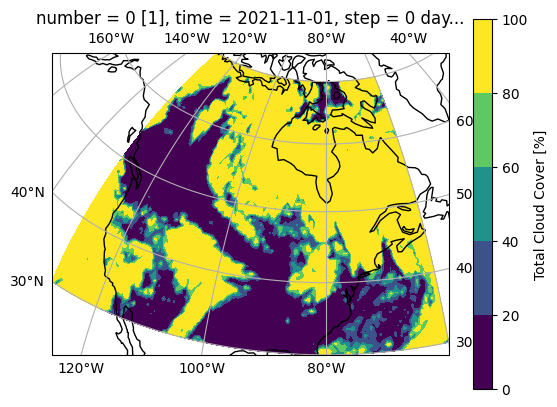

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.coastlines()
ax.gridlines(draw_labels=True)
da.plot.contourf(ax=ax, transform=ccrs.PlateCarree())

### To go further, search using a custom MARS request:

Here we use a set of custom parameters corresponding to `TIGGE_CF_SFC`, which should result to the same request sent to ecmwf.

If you want to eodag from a MARS request obtained from https://apps.ecmwf.int/datasets/data/tigge, you can put in this `ecmwf_req_params` the content of your MARS request without `area` and `date` settings, which must be passed to eodag as `geom`, `start` and `end` parameters.

In [6]:
ecmwf_req_params = {
    "ecmwf:class": "ti",
    "ecmwf:dataset": "tigge",
    "ecmwf:expver": "prod",
    "ecmwf:type": "cf",
    "ecmwf:levtype": "sfc",
    "ecmwf:origin": "ecmwf",
    "ecmwf:grid": "0.5/0.5",
    "ecmwf:step": 0,
    "ecmwf:time": "00:00",
    "ecmwf:param": "tcc",
    "ecmwf:target": "output",

}

products_from_mars_req = dag.search(
    geom={
        "latmax": 70,
        "lonmax": -130,
        "latmin": 30,
        "lonmin": -60,
    },
    start="2021-11-01",
    end="2021-11-02",
    **ecmwf_req_params
)
# title and downloadLink properties must be the same with the two request methods,
# as they are built from ECMWF request arguments
if (
    products_from_mars_req[0].properties["title"]
    == products_from_product_type[0].properties["title"]
    and products_from_mars_req[0].properties["downloadLink"]
    == products_from_product_type[0].properties["downloadLink"]
):
    print(
        "Request using productType or directly MARS parameters result to the \n",
        "same product title %s \n and downloadLink %s"
        % (
            products_from_mars_req[0].properties["title"],
            products_from_mars_req[0].properties["downloadLink"],
        )
    )

Request using productType or directly MARS parameters result to the 
 same product title TIGGE_CF_SFC_20211101_20211102_6d2c178d29fcec77d7bed57ac73ec354bfecdc8e 
 and downloadLink https://apps.ecmwf.int/datasets/data/?{"area": ["70.0/-130.0/30.0/-60.0"], "class": "ti", "dataset": "tigge", "date": ["2021-11-01/to/2021-11-01"], "expver": "prod", "grid": "0.5/0.5", "levtype": "sfc", "origin": "ecmwf", "param": "tcc", "step": "0", "target": "output", "time": "00:00", "type": "cf"}
